In [2]:
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string as s
import re

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Análisis de los atributos

In [3]:
dataset= pd.read_csv('/Users/goros/Downloads/Kaggle/clickbait_data.csv')
dataset.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [4]:
x = dataset['headline']
y = dataset['clickbait']

In [5]:
print("Dimensionalidad de la BBDD:", dataset.shape)
print("Dimensionalidad de las entradas X", x.shape)
print("Dimensionalidad del atributo Y", y.shape, "\n")


print("Para contar el número de valores no existentes:")
print(dataset.isnull().sum())

print("\nComo se puede observar no existe ningun valor no existente, por lo que no será necesario asignar nigún valor o borrar ningún atributo.")

Dimensionalidad de la BBDD: (32000, 2)
Dimensionalidad de las entradas X (32000,)
Dimensionalidad del atributo Y (32000,) 

Para contar el número de valores no existentes:
headline     0
clickbait    0
dtype: int64

Como se puede observar no existe ningun valor no existente, por lo que no será necesario asignar nigún valor o borrar ningún atributo.


In [6]:
# tipo de cada atributo
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


In [7]:
print("\nMostramos las estadísticas de los atributos númericos de la BBDD:")
dataset.describe()


Mostramos las estadísticas de los atributos númericos de la BBDD:


,clickbait
count,32000.000000
mean,0.499969
std,0.500008
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


C:\Users\goros\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='clickbait', ylabel='count'>

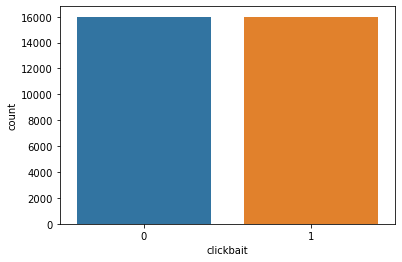

In [8]:
sns.countplot(dataset.clickbait)

# Aplicación de diversos métodos de aprendizaje

## Detector clickbait con vectorizador de recuento

 ### División en conjuntos de tren y prueba

El conjunto de datos se divide en conjuntos de entrenamiento y prueba. El porcentaje de datos de entrenamiento es del 75% y los datos de prueba son del 25%

In [9]:
x=dataset.headline
y=dataset.clickbait
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.25,random_state=22,stratify=dataset['clickbait'])

### Análisis de datos de entrenamiento y prueba

In [10]:
print("Número de elementos en el test de entrenamiento")
print(train_x.size)
print("Número de elementos en el test de prueba")
print(test_x.size)

Número de elementos en el test de entrenamiento
24000
Número de elementos en el test de prueba
8000


In [11]:
print(train_x.head())
print(train_y.head())

16963    California's same-sex marriage ban ruled uncon...
31283    Sports-heavy broadcast day for BBC One receive...
22340    Report says disappearing life threatens biodiv...
24344    UN accuses US of wholesale rights violations i...
2219     5 Ridiculous Things Science Claimed About Bear...
Name: headline, dtype: object
16963    0
31283    0
22340    0
24344    0
2219     1
Name: clickbait, dtype: int64


In [12]:
print(test_x.head())
print(test_y.head())

31858                 Indian Ocean tsunami, one year after
20688    UN carries out first review of US human rights...
19125    Pirate Bay case: Internet group attacks websit...
13523             How Many Iconic '70s Films Have You Seen
3473        How Much Do You Really Know About "Doctor Who"
Name: headline, dtype: object
31858    0
20688    0
19125    0
13523    1
3473     1
Name: clickbait, dtype: int64


### Tokenización de datos

Los datos se "tokenizan", es decir, se dividen en tokens que son las unidades significativas más pequeñas o mínimas. Los datos se dividen en palabras.

In [13]:
def tokenization(text):
    lst=text.split()
    return lst
train_x=train_x.apply(tokenization)
test_x=test_x.apply(tokenization)

### Conversión a minúsculas

Los datos se convierten en minúsculas para evitar la ambigüedad entre las mismas palabras en diferentes casos como 'PNL', 'pnl' o 'PNL'.

In [14]:
def lowercasing(lst):
    new_lst=[]
    for i in lst:
        i=i.lower()
        new_lst.append(i)
    return new_lst
train_x=train_x.apply(lowercasing)
test_x=test_x.apply(lowercasing) 

### Eliminación de palabras clave

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\goros\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
def remove_stopwords(lst):
    stop=stopwords.words('english')
    new_lst=[]
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

train_x=train_x.apply(remove_stopwords)
test_x=test_x.apply(remove_stopwords)  

### Eliminación de la puntuación

Las puntuaciones se eliminan para aumentar la eficiencia del modelo. Son irrelevantes porque no proporcionan información adicional.

In [18]:
def remove_punctuations(lst):
    new_lst=[]
    for i in lst:
        for j in s.punctuation:
            i=i.replace(j,'')
        new_lst.append(i)
    return new_lst
train_x=train_x.apply(remove_punctuations)
test_x=test_x.apply(remove_punctuations)

### Eliminación de números

In [19]:
def remove_numbers(lst):
    nodig_lst=[]
    new_lst=[]
    for i in lst:
        for j in s.digits:    
            i=i.replace(j,'')
        nodig_lst.append(i)
    for i in nodig_lst:
        if i!='':
            new_lst.append(i)
    return new_lst
train_x=train_x.apply(remove_numbers)
test_x=test_x.apply(remove_numbers)

### Eliminación de espacios adicionales

In [20]:
def remove_spaces(lst):
    new_lst=[]
    for i in lst:
        i=i.strip()
        new_lst.append(i)
    return new_lst
train_x=train_x.apply(remove_spaces)
test_x=test_x.apply(remove_spaces)

### Análisis de datos después del preprocesamiento

Después de preprocesar los datos, es decir, después de eliminar la puntuación, las palabras clave, los espacios y los números.

In [21]:
train_x.head()

16963    [californias, samesex, marriage, ban, ruled, u...
31283    [sportsheavy, broadcast, day, bbc, one, receiv...
22340    [report, says, disappearing, life, threatens, ...
24344    [un, accuses, us, wholesale, rights, violation...
2219     [ridiculous, things, science, claimed, bearded...
Name: headline, dtype: object

In [22]:
test_x.head()

31858                  [indian, ocean, tsunami, one, year]
20688    [un, carries, first, review, us, human, rights...
19125    [pirate, bay, case, internet, group, attacks, ...
13523                       [many, iconic, s, films, seen]
3473                     [much, really, know, doctor, who]
Name: headline, dtype: object

### Lemmatization

La lemmatización en la lingüística es el proceso de agrupar las formas inflexibles de una palabra para que puedan ser analizadas como un solo elemento, identificado por el lema de la palabra, o forma de diccionario. Implica el análisis morfológico de las palabras. En la lemmatización encontramos la palabra raíz o forma base de la palabra en lugar de simplemente recortar algunos caracteres del extremo, p.ej. es, son, am se convierten a su forma base en Lemmatización Aquí la lemmatización se hace usando la biblioteca NLTK.

In [23]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\goros\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
lemmatizer=nltk.stem.WordNetLemmatizer()
def lemmatzation(lst):
    new_lst=[]
    for i in lst:
        i=lemmatizer.lemmatize(i)
        new_lst.append(i)
    return new_lst
train_x=train_x.apply(lemmatzation)
test_x=test_x.apply(lemmatzation)

In [25]:
train_x=train_x.apply(lambda x: ''.join(i+' ' for i in x))
test_x=test_x.apply(lambda x: ''.join(i+' ' for i in x))

### Countvectoriser

Este método se utiliza para convertir el texto en entidades.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
cov=CountVectorizer(analyzer='word', ngram_range=(1,2),max_features=22500)
train_1=cov.fit_transform(train_x)
test_1=cov.transform(test_x)

In [27]:
train_arr=train_1.toarray()
test_arr=test_1.toarray()

In [28]:
pd.DataFrame(test_arr[:100], columns=cov.get_feature_names())

,aaa,aaron,aaron tveit,ab,abandon,abandoned,abbas,abbey,abbott,abby,...,zombie apocalypse,zone,zoo,zoolander,zotob,zotob worm,zuma,zurich,íngrid,íngrid betancourt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Define Naive Bayes Classifier and training

In [29]:
NB_MN=MultinomialNB()
NB_MN.fit(train_arr,train_y)
pred=NB_MN.predict(test_arr)

### Evaluación de resultados

La precisión y la puntuación F1 del modelo se imprimen para evaluar el modelo para la clasificación del texto.

In [30]:
from sklearn.metrics import f1_score,accuracy_score
print("Puntuación F1 del modelo")
print(f1_score(test_y,pred))
print("Precisión del modelo")
print(accuracy_score(test_y,pred))
print("Precisión del modelo en porcentaje")
print(accuracy_score(test_y,pred)*100,"%")

Puntuación F1 del modelo
0.9593110334498253
Precisión del modelo
0.95925
Precisión del modelo en porcentaje
95.92500000000001 %


In [31]:
from sklearn.metrics import confusion_matrix
print("Matriz de confusión")
print(confusion_matrix(test_y,pred))

from sklearn.metrics import classification_report
print("Informe de clasificación")
print(classification_report(test_y,pred))

Matriz de confusión
[[3831  169]
 [ 157 3843]]
Informe de clasificación
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4000
           1       0.96      0.96      0.96      4000

    accuracy                           0.96      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.96      0.96      0.96      8000



Text(0.5, 1.0, 'Matriz de confusión para la clasificación de Clickbait')

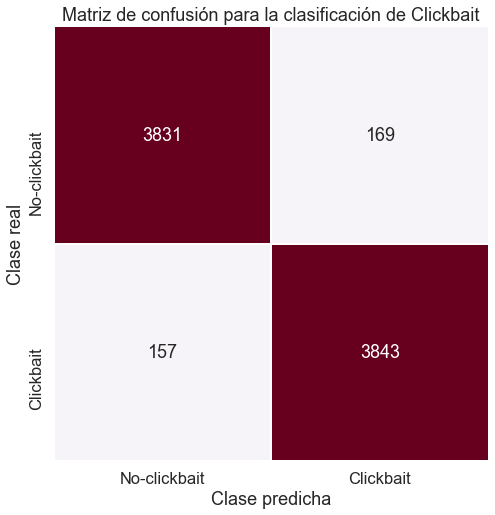

In [32]:
sns.set(font_scale=1.5)
cof=confusion_matrix(test_y, pred)
cof=pd.DataFrame(cof, index=[i for i in range(2)], columns=[i for i in range(2)])
plt.figure(figsize=(8,8))

sns.heatmap(cof, cmap="PuRd",linewidths=1, annot=True,square=True,cbar=False,fmt='d',xticklabels=['No-clickbait','Clickbait'],yticklabels=['No-clickbait','Clickbait'])
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")

plt.title("Matriz de confusión para la clasificación de Clickbait")

## Detector clickbait con vectorizador de recuento

### División entrenamiento-prueba


In [34]:
text = dataset['headline'].values
labels = dataset['clickbait'].values
text_train, text_test, y_train, y_test = train_test_split(text, labels)
print(text_train.shape, text_test.shape, y_train.shape, y_test.shape)

(24000,) (8000,) (24000,) (8000,)


### Tokenize text

In [35]:
vocab_size = 5000
maxlen = 500
embedding_size = 32

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text)

X_train = tokenizer.texts_to_sequences(text_train)
x_test = tokenizer.texts_to_sequences(text_test)

X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

### Definir y entrenar el modelo

In [36]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 500, 32)           8320      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
__________________________________________________

In [37]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [38]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
47/47 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.7959
Epoch 00001: val_accuracy improved from -inf to 0.94012, saving model to weights.h5
47/47 [==============================] - 39s 807ms/step - loss: 0.6462 - accuracy: 0.7959 - val_loss: 0.5436 - val_accuracy: 0.9401
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.9459
Epoch 00002: val_accuracy improved from 0.94012 to 0.96200, saving model to weights.h5
47/47 [==============================] - 47s 1s/step - loss: 0.3694 - accuracy: 0.9459 - val_loss: 0.2241 - val_accuracy: 0.9620
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9703
Epoch 00003: val_accuracy improved from 0.96200 to 0.96700, saving model to weights.h5
47/47 [==============================] - 48s 1s/step - loss: 0.1637 - accuracy: 0.9703 - val_loss: 0.1251 - val_accuracy: 0.9670
Epoch 4/20
47/47 [==============================] - ETA: 0s - loss: 0.

In [40]:
model.load_weights('weights.h5')
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


### Trazar métricas de entrenamiento

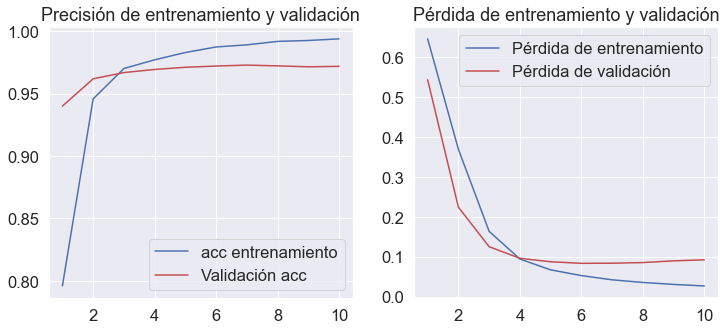

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='acc entrenamiento')
plt.plot(x, val_acc, 'r', label='Validación acc')
plt.title('Precisión de entrenamiento y validación')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Pérdida de entrenamiento')
plt.plot(x, val_loss, 'r', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.legend()
plt.show()

### Trazar matrices y métricas de confusión

<Figure size 432x288 with 0 Axes>

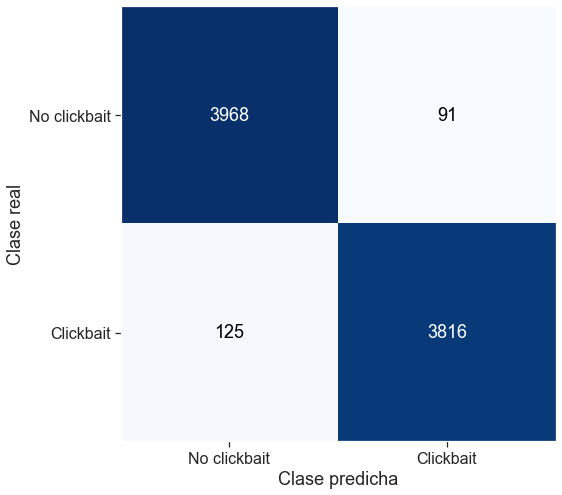

In [53]:
preds = [round(i[0]) for i in model.predict(x_test)]
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['No clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['No clickbait', 'Clickbait'], fontsize=16)
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.show()

In [59]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("La exhaustividad (Recall) del modelo es {:.2f}".format(recall))
print("La precisión del modelo es {:.2f}".format(precision))

La exhaustividad (Recall) del modelo es 0.97
La precisión del modelo es 0.98
